In [2]:
import torch,types,copy
from collections import OrderedDict, defaultdict

import numpy as np

class InstrumentedModel(torch.nn.Module):
    def __init__(self,model):
        super().__init__()
        self.model=model
        self._retained=OrderedDict()
        self._detach_retained={}
        # self._editargs = defaultdict(dict)
        # self._editrule = {}
        self._hooked_layer=[]
        self._old_forward={}
        # if isinstance(model, torch.nn.Sequential):
        #     self._hook_sequential()
    
    def __enter__(self):
        return self
    def __exit__(self, type, value, traceback):
        self.close()
    
    def forward(self,*inputs,**kwargs):
        '''forward it through the original model'''
        return self.model(*inputs,**kwargs)
    
    def retain_layers(self,layernames,detach=True):
        '''retain a list of layers'''
        #to reatin a single layer just call retain_layer([layername])
        self._add_hooks(layernames)
        for layername in layernames:
            if layername not in self._retained:
                self._retained[layername]=None
                self._detach_retained[layername]=detach

    def stop_retaining_layers(self,layernames):
        '''stop retaining a set of retained layers'''
        #check
        for layername in layernames:
            if layername in self._retained:
                del self._retained[layername]
                del self._detach_retained[layername]
                self._unhook_layer(layername)
            else:
                raise ValueError(f"{layername} has not been retained")


    def _add_hooks(self,layernames):
        '''set up layers to be hooked'''
        needed_to_hook=[]
        for layername in layernames:
            if layername not in self._hooked_layer:
                needed_to_hook.append(layername)
        if not needed_to_hook:
            return
        for layername,layer in self.model.named_modules():
            if layername in needed_to_hook:
                self._hook_layer(layer,layername)
                needed_to_hook.remove(layername)
        if needed_to_hook:
            raise ValueError(f'layer {layername} not found in model')
        
    def _hook_layer(self,layer,layername):
        '''
        this modifies the forward of the layer to retain the forward pass layer activations
        '''
        if layername in self._hooked_layer:
            raise ValueError(f'layes {layername} already hooked')
        # if layername in self._old_forward:#?
        #     raise ValueError('Layer %s already hooked' % layername)
        self._hooked_layer.append(layername)
        self._old_forward[layername]=(layer,layer.forward)
        original_forward=layer.forward
        editor=self
        def new_forward(self,*inputs,**kwargs):
            og_x=original_forward(*inputs,**kwargs)
            x=editor._postprocess_forward(og_x,layername)
            return x
        layer.forward=types.MethodType(new_forward,layer)

    def _unhook_layer(self,layername):
        if layername in self._retained:
            del self._retained[layername]
            del self._detach_retained[layername]
        layer,old_forward=self._old_forward[layername]
        #check
        layer.forward=old_forward
        del self.old_forward[layername]
        self._hooked_layer.remove(layername)

    def _postprocess_forward(self,x,layername):
        '''process is run during forward pass to retain activation'''
        if layername in self._retained:
            if self._detach_retained[layername]:
                self._retained[layername]=x.detach()
            else:
                self._retained[layername]=x
            return x
        
    def _retrieve_retained(self,layername=None,clear=False):
        if layername is None:
            #default give the first retained
            layername =self._hooked_layer[0]
        result=self._retained[layername]
        if clear:
            self._retained[layername]=None
        return result

/opt/conda/envs/rosetta/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import torchvision
from scipy.stats import truncnorm

def truncate_noise(size,truncation):
    truncated_noise=truncnorm.rvs(-truncation,truncation,size=size)#
    return torch.tensor(truncated_noise)
def create_dataset(gan,ganmode,batch_size,epochs,classidx,device):
    '''create dataset for GAN'''
    if ganmode=="biggan":
        z_dataset=truncate_noise((batch_size*epochs,128),1).to(device)
        c_dataset=torch.zeros((batch_size*epochs,1000)).to(device)
        c_dataset[:,classidx]=1
    return z_dataset,c_dataset

In [4]:
import torch,torchvision
import tqdm

def get_mean_std(gan,gan_layers,discr,discr_layers,gan_mode,discr_mode,dataset,epochs,batch_size,device):
    '''Get the activation statistics from GAN and discr'''
    print("Collecting Dataset Statistics")
    gan_activs={}
    discr_activs={}
    with torch.no_grad():
        for iteration in tqdm.trange(0, epochs):
            z = dataset[0][iteration*batch_size: (iteration+1)*batch_size ].float()
            c = dataset[1][iteration*batch_size: (iteration+1)*batch_size ].float()
            if gan_mode=="biggan":
                img=gan(z,c,1)
                img=(img+1)/2

            
            for layer in gan_layers:
                if iteration==0:
                    gan_activs[layer]=[]    
                gan_activation=gan._retrieve_retained(layer,clear=True)
                gan_activs[layer].append(gan_activation)

            #clip condition here
            img = torch.nn.functional.interpolate(img, size = (224,224), mode = "bicubic")
            img = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))(img)
            _=discr(img)
            for layer in discr_layers:
                if iteration==0:
                    discr_activs[layer]=[]
                discr_activation=discr._retrieve_retained(layer,clear=True)
                discr_activs[layer].append(discr_activs)
        print("finished iterating for stats")

        
        final_gan_stats={}
        for layer in gan_layers:
            layer_activ_list=gan_activs[layer]
            concat_activs=torch.cat(layer_activ_list,dim=0)
            concat_activs=concat_activs.permute(1,0,2,3).contiguous()
            concat_activs=concat_activs.view(concat_activs.shape[0],-1)
            final_gan_stats[layer]=torch.mean(concat_activs,dim=-1,dtype=torch.float64).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device),\
                                    torch.std(concat_activs,dim=-1,dtype=torch.float64).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)

        final_discr_stats={}
        for layer in discr_layers:
            layer_activ_list=discr_activs[layer]
            concat_activs=torch.cat(layer_activ_list,dim=0)
            concat_activs=concat_activs.permute(1,0,2,3).contiguous()
            concat_activs=concat_activs.view(concat_activs.shape[0],-1)
            final_discr_stats[layer]=torch.mean(concat_activs,dim=-1,dtype=torch.float64).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device),\
                                    torch.std(concat_activs,dim=-1,dtype=torch.float64).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)
        
        return final_gan_stats,final_discr_stats

In [5]:
def get_mean_std1(gan, gan_layers, discr, discr_layers, gan_mode, discr_mode, dataset, epochs, batch_size, device):
    '''Get activation statistics over dataset for GAN and discriminative model.'''
    
    print("Collecting Dataset Statistics")
    gan_stats_list = []
    discr_stats_list = []
    with torch.no_grad():
        for iteration in tqdm.trange(0, epochs):
            z = dataset[0][iteration*batch_size: (iteration+1)*batch_size ]
            c = dataset[1][iteration*batch_size: (iteration+1)*batch_size ]
            
            if gan_mode == "biggan":
                img = gan(z,c,1)
                img = (img+1)/2
            elif gan_mode == "stylegan3-afhq":
                img = gan(z,c)
                img = (img+1)/2
            elif gan_mode == "projgan":
                img = gan(z,c, truncation_psi = 0.7)
                img = (img+1)/2
            elif gan_mode == "styleganxl":
                img = gan(z,c, truncation_psi = 0.5)
                img = (img+1)/2
            elif "stylegan2" in gan_mode:
                img, _  = gan([z], 0.7, c)
                img = (img+1)/2

            #### append GAN layer activations for batch
            gan_activs = {}
            for layer in gan_layers:
                gan_activs[layer] = []    
                gan_activation = gan.retained_layer(layer, clear = True)
                gan_activs[layer].append(gan_activation)
            #### Prepare images for discriminator
            
            if discr_mode == "clip":
                img = torch.nn.functional.interpolate(img, size = (224,224), mode = "bicubic")
                img = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))(img)
                _ = discr.model.encode_image(img)
            else:
                img = torch.nn.functional.interpolate(img, size = (224,224), mode = "bicubic")
                img = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img)
                _ = discr(img)

            del img
            
            discr_activs = {}
            for layer in discr_layers:
                discr_activs[layer] = []
                discr_activation = discr.retained_layer(layer, clear = True)
                discr_activs[layer].append(discr_activation)
            batch_gan_stats_list = []
            for layer in gan_layers:
                gan_activs[layer] = torch.cat(gan_activs[layer], 0) #images x channels x m x m
                gan_activs[layer] = torch.permute(gan_activs[layer], (1,0,2,3)).contiguous() #channels x images x m x m
                gan_activs[layer] = gan_activs[layer].view(gan_activs[layer].shape[0], -1) 
                batch_gan_stats_list.append([torch.mean(gan_activs[layer],dim=-1, dtype=torch.float64).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device),\
                                      torch.std(gan_activs[layer], dim=-1).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)])
            del gan_activs
            gan_stats_list.append(batch_gan_stats_list)

            batch_discr_stats_list = []
            discr_stats_list.append(batch_discr_stats_list)
            for layer in discr_layers:
                discr_activs[layer] = torch.cat(discr_activs[layer], 0)
                discr_activs[layer] = torch.permute(discr_activs[layer], (1,0,2,3)).contiguous()
                discr_activs[layer] = discr_activs[layer].view(discr_activs[layer].shape[0], -1)
                batch_discr_stats_list.append([torch.mean(discr_activs[layer], dim=-1, dtype=torch.float64).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device),\
                                      torch.std(discr_activs[layer], dim=-1).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)])

            del discr_activs
            torch.cuda.empty_cache()

    
    ####################### After iterating
        print("Finished Iterating for Stats")
        final_discr_stats_list = []

        for iii in range(len(batch_discr_stats_list)):
            means = torch.zeros_like(batch_discr_stats_list[iii][0])
            stds = torch.zeros_like(batch_discr_stats_list[iii][1])
            for jjj in range(epochs):
                means+=discr_stats_list[jjj][iii][0]
                stds+=discr_stats_list[jjj][iii][1]**2

            final_discr_stats_list.append([means/epochs, torch.sqrt(stds/epochs)])



        final_gan_stats_list = []

        for iii in range(len(batch_gan_stats_list)):
            means = torch.zeros_like(batch_gan_stats_list[iii][0])
            stds = torch.zeros_like(batch_gan_stats_list[iii][1])
            for jjj in range(epochs):
                means+=gan_stats_list[jjj][iii][0]
                stds+=gan_stats_list[jjj][iii][1]**2

            final_gan_stats_list.append([means/epochs, torch.sqrt(stds/epochs)])




    return final_gan_stats_list, final_discr_stats_list


In [6]:
from pytorch_pretrained_biggan import BigGAN
from torchvision.models import resnet50

In [7]:
gan=BigGAN.from_pretrained('biggan-deep-256')
gan_layers=[]
for name,layer in gan.named_modules():
    if "conv" in name:
        gan_layers.append(name)
discr=resnet50(num_classes=1000,pretrained='imagenet')
discr_layers = [ "layer1", "layer2", "layer3", "layer4"]
for p in discr.parameters(): 
    p.data = p.data.float()

/opt/conda/envs/rosetta/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
gan=InstrumentedModel(gan)
gan.retain_layers(gan_layers)

discr=InstrumentedModel(discr)
discr.retain_layers(discr_layers)


In [9]:
batch_size=8
epochs=10
device=torch.device("cpu")
z_dataset,c_dataset=create_dataset(gan,'biggan',batch_size,epochs,0,device)
get_mean_std(gan,gan_layers,discr,discr_layers,'biggan','resnet50',(z_dataset,c_dataset),epochs,batch_size,device)

  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/envs/rosetta/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
 10%|█         | 1/10 [00:12<01:55, 12.87s/it]

: 

In [10]:
"""
startup:
tested for: gan._retained,gan._hooked_layer,gan._old_forward,gan._detach_retained
and new forward:
for layername,layer in gan.model.named_modules():
    if layername in gan._hooked_layer:
        print(layer.forward)
"""

'\nstartup:\ntested for: gan._retained,gan._hooked_layer,gan._old_forward,gan._detach_retained\nand new forward:\nfor layername,layer in gan.model.named_modules():\n    if layername in gan._hooked_layer:\n        print(layer.forward)\n'

In [11]:
for layername,layer in gan.model.named_modules():
    if layername in gan._hooked_layer:
        print(layer.forward)

<bound method InstrumentedModel._hook_layer.<locals>.new_forward of Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1))>
<bound method InstrumentedModel._hook_layer.<locals>.new_forward of Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))>
<bound method InstrumentedModel._hook_layer.<locals>.new_forward of Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))>
<bound method InstrumentedModel._hook_layer.<locals>.new_forward of Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1))>
<bound method InstrumentedModel._hook_layer.<locals>.new_forward of Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1))>
<bound method InstrumentedModel._hook_layer.<locals>.new_forward of Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))>
<bound method InstrumentedModel._hook_layer.<locals>.new_forward of Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))>
<bound method InstrumentedModel._hook_layer.<locals>.new_forward of Conv2d(512, 2048, 

In [11]:
z_dataset,c_dataset=create_dataset(gan,'biggan',1,10,0,torch.device("cpu"))

In [12]:
z1=z_dataset[0:1].float()
c1=c_dataset[0:1].float()

In [13]:
z1=torch.zeros_like(z1)

In [14]:
z1.shape,c1.shape

(torch.Size([1, 128]), torch.Size([1, 1000]))

In [15]:
img=gan(z1,c1,1)

In [16]:
something=gan._retrieve_retained()

In [17]:
img=(img+1)/2

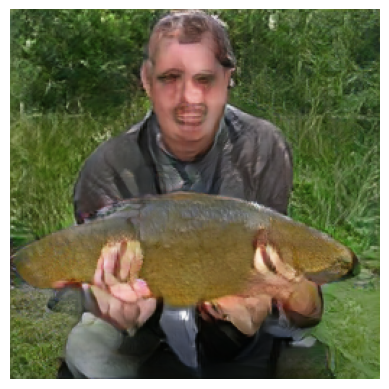

In [18]:
import matplotlib.pyplot as plt
img_np=img.squeeze().permute(1,2,0).detach().numpy()
plt.imshow(img_np)
plt.axis('off')
plt.show()

In [ ]:
for layername in gan_layers:
    block_activation=gan._retained[layername]
    if block_activation.shape[3]==64:
        num_channels = block_activation.shape[1]
        # Calculate the number of rows and columns for the subplot grid
        rows = int(num_channels**0.5)
        cols = (num_channels + rows - 1) // rows

        # Create a subplot grid
        fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

        # Iterate through each channel and display it in a subplot
        for i in range(num_channels):
            ax = axes[i // cols, i % cols] if num_channels > 1 else axes
            ax.imshow(block_activation[0, i, :, :].detach().numpy(), cmap='viridis')
            ax.axis('off')
            ax.set_title(f'Channel {i}')

        # Adjust layout for better spacing
        plt.tight_layout()
        plt.show()
        break